In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
import seaborn
import pprint
import deepdiff
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.gbm import GBM
from rivapy.instruments.specifications import EuropeanVanillaSpecification
from rivapy.pricing.vanillaoption_pricing import VanillaOptionDeepHedgingPricer, DeepHedgeModel 


import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\sandbox\vanillaoption\../..\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


In [3]:
np.random.seed(42)
n = 30#365
T = 30/365
timegrid = np.linspace(0.0,T,n) # simulate on daily timegrid over 30 days
model = GBM(drift = 0., volatility=0.2)
n_sims = 100
S0 = 1.
paths = model.simulate(timegrid, start_value=S0,M = n_sims, n=n)


Text(0, 0.5, 'S(t)')

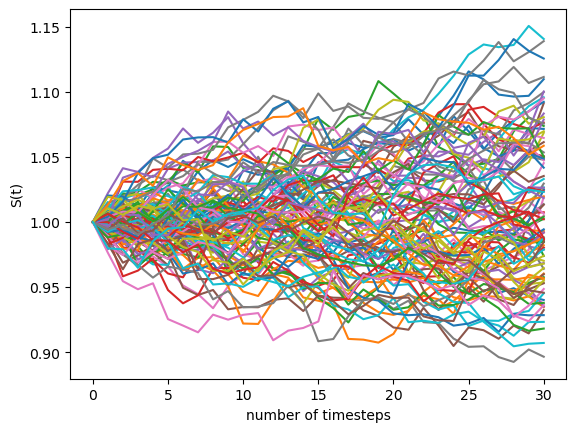

In [4]:
plt.plot(paths)
plt.xlabel('number of timesteps')
plt.ylabel('S(t)')

In [5]:
refdate = dt.datetime(2023,1,1)
issuer = 'DBK'
seclevel = 'COLLATERALIZED'
currency = 'EUR'
tpe = 'CALL' # Change to 'PUT' if you want to calculate the price of an european put option.
expiry = refdate + dt.timedelta(days=30)
strike = 1.
spec = EuropeanVanillaSpecification('Test_call', tpe, expiry, strike, 
                                                       issuer = issuer, sec_lvl = seclevel, curr='EUR',udl_id='ADS',
                                                       share_ratio = 1)

In [8]:
test =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=2,#3, 
                                      nb_neurons=32,#64, 
                                      n_sims=100_000, 
                                      regularization=1.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=0.005,#5e-4,
                                      decay_steps=8_000,
                                      batch_size=256, 
                                      decay_rate=0.8, 
                                      seed=42,transaction_cost = {'ADS': [1.e-10]},loss ='exponental utility')

Epoch 1/10
352/352 [==============================] - 9s 12ms/step - loss: 0.0239
Epoch 2/10
352/352 [==============================] - 5s 14ms/step - loss: 0.0237
Epoch 3/10
352/352 [==============================] - 5s 15ms/step - loss: 0.0236
Epoch 4/10
352/352 [==============================] - 5s 14ms/step - loss: 0.0236
Epoch 5/10
352/352 [==============================] - 7s 19ms/step - loss: 0.0236 - val_loss: 0.0238
Epoch 6/10
352/352 [==============================] - 5s 15ms/step - loss: 0.0236
Epoch 7/10
352/352 [==============================] - 5s 15ms/step - loss: 0.0236
Epoch 8/10
352/352 [==============================] - 5s 15ms/step - loss: 0.0236
Epoch 9/10
352/352 [==============================] - 6s 16ms/step - loss: 0.0235
Epoch 10/10
352/352 [==============================] - 6s 16ms/step - loss: 0.0237 - val_loss: 0.0237


In [7]:
inputs = test.hedge_model._create_inputs(test.paths)
loss_test = test.hedge_model.evaluate(inputs, test.payoff)

3125/3125 [==============================] - 8s 2ms/step - loss: 1.8451e-05


In [8]:
print(loss_test)

1.8450597053742968e-05


In [ ]:
indiffprice_test = test.hedge_model.(pricing_result.paths, pricing_result.payoff)

In [114]:
test_th8 =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [1.e-10]},threshold = 5.)#,cascading = True)#,loss ='expected_shortfall')#,transaction_cost = {'vanillaoption': [1.e-10]})

Epoch 1/10
900/900 [==============================] - 13s 10ms/step - loss: 1.6890e-04
Epoch 2/10
900/900 [==============================] - 9s 9ms/step - loss: 5.3766e-05
Epoch 3/10
900/900 [==============================] - 8s 9ms/step - loss: 5.0870e-05
Epoch 4/10
900/900 [==============================] - 11s 12ms/step - loss: 4.6336e-05
Epoch 5/10
900/900 [==============================] - 14s 16ms/step - loss: 4.2499e-05 - val_loss: 3.8793e-05
Epoch 6/10
900/900 [==============================] - 10s 11ms/step - loss: 3.4707e-05
Epoch 7/10
900/900 [==============================] - 10s 11ms/step - loss: 2.6342e-05
Epoch 8/10
900/900 [==============================] - 10s 11ms/step - loss: 2.2543e-05
Epoch 9/10
900/900 [==============================] - 10s 11ms/step - loss: 2.1060e-05
Epoch 10/10
900/900 [==============================] - 11s 12ms/step - loss: 1.9401e-05 - val_loss: 2.0468e-05


In [102]:
test_casc =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [1.e-10]},cascading = True)#,loss ='expected_shortfall')#,transaction_cost = {'vanillaoption': [1.e-10]})

Epoch 1/10
900/900 [==============================] - 18s 13ms/step - loss: 2.1306e-04
Epoch 2/10
900/900 [==============================] - 11s 12ms/step - loss: 1.0584e-04
Epoch 3/10
900/900 [==============================] - 10s 11ms/step - loss: 9.7620e-05
Epoch 4/10
900/900 [==============================] - 13s 14ms/step - loss: 9.2582e-05
Epoch 5/10
900/900 [==============================] - 19s 21ms/step - loss: 9.4500e-05 - val_loss: 9.5381e-05
Epoch 6/10
900/900 [==============================] - 11s 12ms/step - loss: 9.3193e-05
Epoch 7/10
900/900 [==============================] - 10s 11ms/step - loss: 9.1753e-05
Epoch 8/10
900/900 [==============================] - 10s 11ms/step - loss: 9.1097e-05
Epoch 9/10
900/900 [==============================] - 10s 11ms/step - loss: 9.0672e-05
Epoch 10/10
900/900 [==============================] - 18s 20ms/step - loss: 8.4688e-05 - val_loss: 8.6678e-05


In [103]:
pricing_result_ES =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.5,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.8, 
                                      seed=42,loss ='expected_shortfall')#,transaction_cost = {'vanillaoption': [1.e-10]})

Epoch 1/10
900/900 [==============================] - 14s 12ms/step - loss: 0.0353
Epoch 2/10
900/900 [==============================] - 11s 13ms/step - loss: 0.0291
Epoch 3/10
900/900 [==============================] - 11s 13ms/step - loss: 0.0284
Epoch 4/10
900/900 [==============================] - 11s 12ms/step - loss: 0.0280
Epoch 5/10
900/900 [==============================] - 13s 15ms/step - loss: 0.0273 - val_loss: 0.0277
Epoch 6/10
900/900 [==============================] - 12s 13ms/step - loss: 0.0269
Epoch 7/10
900/900 [==============================] - 11s 12ms/step - loss: 0.0268
Epoch 8/10
900/900 [==============================] - 12s 13ms/step - loss: 0.0269
Epoch 9/10
900/900 [==============================] - 11s 12ms/step - loss: 0.0269
Epoch 10/10
900/900 [==============================] - 12s 14ms/step - loss: 0.0266 - val_loss: 0.0271


In [104]:
pricing_result =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=50, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.8, 
                                      seed=42)#,loss ='exponential_utility')#,transaction_cost = {'vanillaoption': [1.e-10]})

Epoch 1/50
900/900 [==============================] - 15s 13ms/step - loss: 1.2450e-04
Epoch 2/50
900/900 [==============================] - 11s 12ms/step - loss: 4.8483e-05
Epoch 3/50
900/900 [==============================] - 11s 12ms/step - loss: 4.5058e-05
Epoch 4/50
900/900 [==============================] - 11s 12ms/step - loss: 3.9899e-05
Epoch 5/50
900/900 [==============================] - 12s 14ms/step - loss: 3.2780e-05 - val_loss: 2.5453e-05
Epoch 6/50
900/900 [==============================] - 10s 12ms/step - loss: 2.5731e-05
Epoch 7/50
900/900 [==============================] - 11s 12ms/step - loss: 2.2698e-05
Epoch 8/50
900/900 [==============================] - 11s 12ms/step - loss: 2.2227e-05
Epoch 9/50
900/900 [==============================] - 11s 12ms/step - loss: 2.1175e-05
Epoch 10/50
900/900 [==============================] - 11s 12ms/step - loss: 1.9520e-05 - val_loss: 2.0677e-05
Epoch 11/50
900/900 [==============================] - 11s 13ms/step - loss: 1.9739

In [105]:
pricing_result_wtc =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [1.e-10]})#,loss ='exponential_utility')

Epoch 1/10
900/900 [==============================] - 15s 12ms/step - loss: 1.8947e-04
Epoch 2/10
900/900 [==============================] - 10s 12ms/step - loss: 5.5371e-05
Epoch 3/10
900/900 [==============================] - 10s 12ms/step - loss: 5.3678e-05
Epoch 4/10
900/900 [==============================] - 10s 12ms/step - loss: 4.9971e-05
Epoch 5/10
900/900 [==============================] - 13s 15ms/step - loss: 4.7499e-05 - val_loss: 5.4280e-05
Epoch 6/10
900/900 [==============================] - 11s 12ms/step - loss: 4.1924e-05
Epoch 7/10
900/900 [==============================] - 10s 11ms/step - loss: 3.5040e-05
Epoch 8/10
900/900 [==============================] - 10s 12ms/step - loss: 2.4776e-05
Epoch 9/10
900/900 [==============================] - 10s 12ms/step - loss: 2.1717e-05
Epoch 10/10
900/900 [==============================] - 11s 12ms/step - loss: 1.9678e-05 - val_loss: 2.0280e-05


In [106]:
pricing_result_wtc0001 =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [0.0001]})#loss ='exponential_utility',

Epoch 1/10
900/900 [==============================] - 16s 12ms/step - loss: 1.4489e-04
Epoch 2/10
900/900 [==============================] - 11s 12ms/step - loss: 4.9923e-05
Epoch 3/10
900/900 [==============================] - 10s 12ms/step - loss: 4.7580e-05
Epoch 4/10
900/900 [==============================] - 10s 12ms/step - loss: 4.1740e-05
Epoch 5/10
900/900 [==============================] - 13s 15ms/step - loss: 3.4086e-05 - val_loss: 2.7755e-05
Epoch 6/10
900/900 [==============================] - 10s 11ms/step - loss: 2.4902e-05
Epoch 7/10
900/900 [==============================] - 10s 12ms/step - loss: 2.2096e-05
Epoch 8/10
900/900 [==============================] - 10s 12ms/step - loss: 2.1605e-05
Epoch 9/10
900/900 [==============================] - 11s 12ms/step - loss: 2.1044e-05
Epoch 10/10
900/900 [==============================] - 11s 13ms/step - loss: 1.9402e-05 - val_loss: 1.8873e-05


In [107]:
pricing_result_wtc001 =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [0.001]})#loss ='exponential_utility',

Epoch 1/10
900/900 [==============================] - 15s 12ms/step - loss: 2.0679e-04
Epoch 2/10
900/900 [==============================] - 11s 12ms/step - loss: 5.3482e-05
Epoch 3/10
900/900 [==============================] - 11s 12ms/step - loss: 5.1377e-05
Epoch 4/10
900/900 [==============================] - 11s 12ms/step - loss: 4.7081e-05
Epoch 5/10
900/900 [==============================] - 13s 14ms/step - loss: 4.3637e-05 - val_loss: 4.0541e-05
Epoch 6/10
900/900 [==============================] - 10s 11ms/step - loss: 3.6701e-05
Epoch 7/10
900/900 [==============================] - 10s 11ms/step - loss: 2.8814e-05
Epoch 8/10
900/900 [==============================] - 10s 11ms/step - loss: 2.4201e-05
Epoch 9/10
900/900 [==============================] - 10s 12ms/step - loss: 2.2541e-05
Epoch 10/10
900/900 [==============================] - 11s 12ms/step - loss: 2.0419e-05 - val_loss: 2.1054e-05


In [108]:
pricing_result_wtc01 =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.,
                                      epochs=10, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, 
                                      decay_rate=0.8, 
                                      seed=42,transaction_cost = {'vanillaoption': [0.01]})#loss ='exponential_utility',

Epoch 1/10
900/900 [==============================] - 15s 11ms/step - loss: 1.5987e-04
Epoch 2/10
900/900 [==============================] - 10s 11ms/step - loss: 6.1547e-05
Epoch 3/10
900/900 [==============================] - 10s 11ms/step - loss: 5.5632e-05
Epoch 4/10
900/900 [==============================] - 10s 11ms/step - loss: 5.0009e-05
Epoch 5/10
900/900 [==============================] - 12s 13ms/step - loss: 4.0824e-05 - val_loss: 3.3200e-05
Epoch 6/10
900/900 [==============================] - 9s 10ms/step - loss: 3.3263e-05
Epoch 7/10
900/900 [==============================] - 9s 10ms/step - loss: 3.1540e-05
Epoch 8/10
900/900 [==============================] - 9s 10ms/step - loss: 3.0795e-05
Epoch 9/10
900/900 [==============================] - 9s 10ms/step - loss: 2.9810e-05
Epoch 10/10
900/900 [==============================] - 10s 11ms/step - loss: 2.8202e-05 - val_loss: 2.7736e-05


In [53]:
pnl = pricing_result.hedge_model.compute_pnl(pricing_result.paths, pricing_result.payoff)
inputs = pricing_result.hedge_model._create_inputs(pricing_result.paths)
loss = pricing_result.hedge_model.evaluate(inputs, pricing_result.payoff)

test = {'mean': pnl.mean(), 'var': pnl.var(), 
            'loss': loss,
            '1%':np.percentile(pnl,1), '99%': np.percentile(pnl,99),
            '5%':np.percentile(pnl,5), '95%': np.percentile(pnl,95)}

3125/3125 [==============================] - 7s 2ms/step - loss: 1.7808e-05


In [109]:
pnl = pricing_result.hedge_model.compute_pnl(pricing_result.paths, pricing_result.payoff)
pnl_wtc = pricing_result_wtc.hedge_model.compute_pnl(pricing_result_wtc.paths, pricing_result_wtc.payoff)
pnl_wtc0001 = pricing_result_wtc0001.hedge_model.compute_pnl(pricing_result_wtc0001.paths, pricing_result_wtc0001.payoff)
pnl_wtc001 = pricing_result_wtc001.hedge_model.compute_pnl(pricing_result_wtc001.paths, pricing_result_wtc001.payoff)
pnl_wtc01 = pricing_result_wtc01.hedge_model.compute_pnl(pricing_result_wtc01.paths, pricing_result_wtc01.payoff)

3125/3125 [==============================] - 10s 3ms/step


In [120]:
pnl_test_th8 = test_th8.hedge_model.compute_pnl(test_th8.paths, test_th8.payoff)
pnl_test_casc = test_casc.hedge_model.compute_pnl(test_casc.paths, test_casc.payoff)

3125/3125 [==============================] - 8s 3ms/step


Text(0.5, 0, 'PnL')

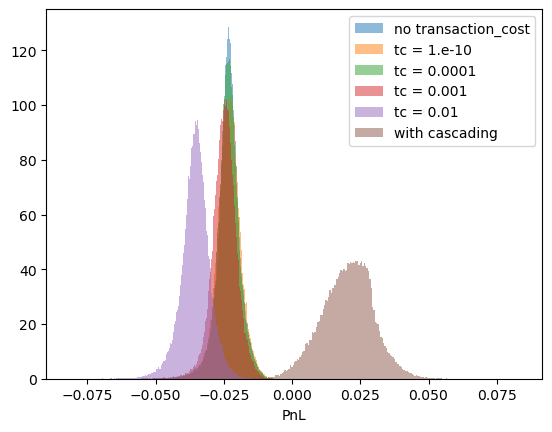

In [121]:
#plt.hist(pnl_test_th8, bins=200, label='with trading restriction/th=5', density=True, alpha=0.5)
plt.hist(pnl, bins=200, label='no transaction_cost', density=True, alpha=0.5)
plt.hist(pnl_wtc, bins=200, label='tc = 1.e-10', density=True, alpha=0.5)
plt.hist(pnl_wtc0001, bins=200, label='tc = 0.0001', density=True, alpha=0.5)
plt.hist(pnl_wtc001, bins=200, label='tc = 0.001', density=True, alpha=0.5)
plt.hist(pnl_wtc01, bins=200, label='tc = 0.01', density=True, alpha=0.5)
plt.hist(pnl_test_casc, bins=200, label='with cascading', density=True, alpha=0.5)
plt.legend()
plt.xlabel('PnL')

In [122]:
t = -2
delta = pricing_result.hedge_model.compute_delta(pricing_result.paths, t).reshape((-1,))


3125/3125 [==============================] - 2s 702us/step


In [123]:
t = -2
delta_wtc = pricing_result_wtc.hedge_model.compute_delta(pricing_result_wtc.paths, t).reshape((-1,))
delta_wtc0001 = pricing_result_wtc0001.hedge_model.compute_delta(pricing_result_wtc0001.paths, t).reshape((-1,))
delta_wtc001 = pricing_result_wtc001.hedge_model.compute_delta(pricing_result_wtc001.paths, t).reshape((-1,))
delta_wtc01 = pricing_result_wtc01.hedge_model.compute_delta(pricing_result_wtc01.paths, t).reshape((-1,))

3125/3125 [==============================] - 2s 783us/step


In [124]:
t = -2
delta_ES = pricing_result_ES.hedge_model.compute_delta(pricing_result_ES.paths, t).reshape((-1,))

3125/3125 [==============================] - 3s 843us/step


In [125]:
v = pricing_result.paths
v = v['vanillaoption']

v_wtc = pricing_result_wtc.paths
v_wtc = v_wtc['vanillaoption']

v_wtc0001 = pricing_result_wtc0001.paths
v_wtc0001 = v_wtc0001['vanillaoption']

v_wtc001 = pricing_result_wtc001.paths
v_wtc001 = v_wtc001['vanillaoption']

v_wtc01 = pricing_result_wtc01.paths
v_wtc01 = v_wtc01['vanillaoption']

v_ES = pricing_result_ES.paths
v_ES = v_ES['vanillaoption']

0.03688702080172552


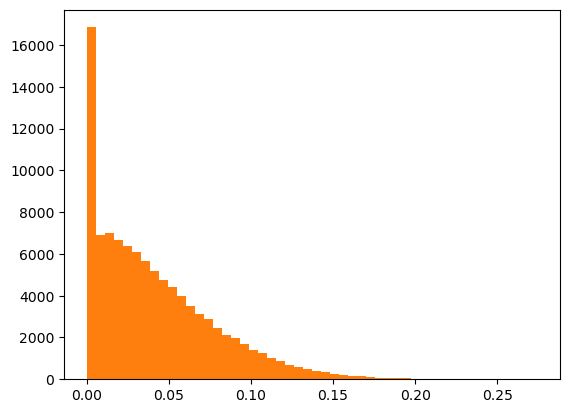

In [90]:
plt.hist(np.max(v-1.,0), bins=50)
plt.hist(np.max(v_wtc-1.,0), bins=50)
payoff = np.max(v-1.,0)
print(np.std(np.max(v-1.,0)))

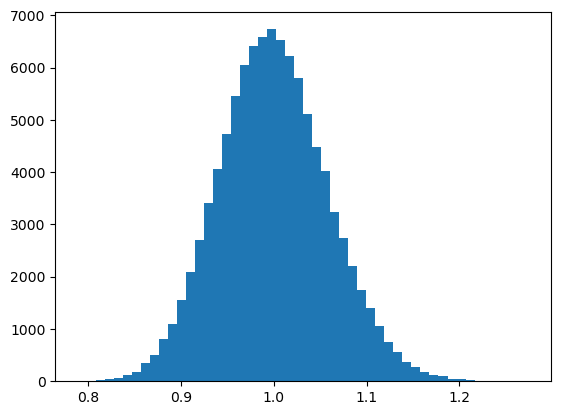

In [91]:
plt.hist(v[-1,:],bins = 50);

In [126]:
import scipy
t = -2
drift = 0.0
volatility=0.2
S = np.linspace(0.8,1.2,30)
d1 = (np.log(S/1.) + (drift + volatility*volatility*0.5)*(model._delta_t))/(volatility*np.sqrt(model._delta_t))

delta_BS = scipy.stats.norm.cdf(d1)

print(delta_BS)


[8.96544719e-98 1.08736396e-83 6.23676000e-71 1.95203984e-59
 3.81626547e-49 5.29529184e-40 5.88605999e-32 5.88077650e-25
 5.89485015e-19 6.59024316e-14 9.11071124e-10 1.72686686e-06
 5.00175177e-04 2.51022595e-02 2.59580458e-01 7.42418551e-01
 9.73113015e-01 9.99286994e-01 9.99995360e-01 9.99999992e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


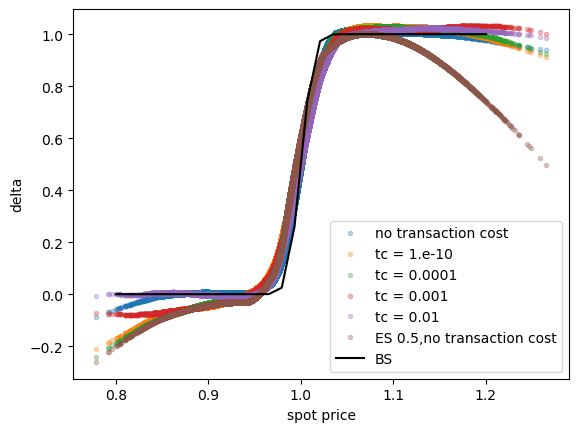

In [127]:

plt.plot(v[t,:], delta,'.', label='no transaction cost', alpha=0.3)
plt.plot(v_wtc[t,:], delta_wtc,'.', label='tc = 1.e-10', alpha=0.3)
plt.plot(v_wtc0001[t,:], delta_wtc0001,'.', label='tc = 0.0001', alpha=0.3)
plt.plot(v_wtc001[t,:], delta_wtc001,'.', label='tc = 0.001', alpha=0.3)
plt.plot(v_wtc01[t,:], delta_wtc01,'.', label='tc = 0.01', alpha=0.3)
plt.plot(v_ES[t,:], delta_ES,'.', label='ES 0.5,no transaction cost', alpha=0.3)
plt.plot(S,delta_BS,label='BS',color='black')
plt.xlabel('spot price')
plt.ylabel('delta')
plt.legend()

# Experiments

In [74]:
def setup(ref_key, ref_key_volume_hedge):
    sim_results = {}
    paths = {}
    pnl = {}
    delta = {}
    # simulate paths
    print('simulate paths')
    for k in ref_keys:
        print(k)
        sim_results[k] = repo.simulate_model(k, n_sims=100_000)

    print(sim_results)
    paths = {k:{'ADS':sim_results[k]} for k in ref_keys}
    # load models and specs
    print('load models and specs')
    hedge_models = {k: repo.get_hedge_model(k) for k in ref_keys}
    specs = {k: EuropeanVanillaSpecification.from_dict(repo.results[k]['spec']) for k in ref_keys}
    #compute pathwise pnls
    print('compute pnl')

    print(paths.keys())

    for k,v in hedge_models.items():
        pnl[k], delta[k] = compute_payoff(100_000, sim_results[k], specs[k], paths[k], hedge_models[k])

        
    return sim_results, hedge_models, specs, paths, pnl, delta 

def compute_payoff(n_sims, hedge_ins, specs, paths, hedge_model):
    pnl = {}
    delta = {}
    payoff = np.zeros((n_sims,))
    for k,v in paths.items(): 
        payoff -= np.maximum(v[-1,:] - specs.strike,0)

    pnl = hedge_model.compute_pnl(paths, payoff)
    delta = hedge_model.compute_delta(paths, -2).reshape((-1,))
    return pnl, delta






In [14]:
repo = analysis.Repo('./experiments/')

In [15]:
repo.results.keys()

dict_keys(['09f5c799482991af1733e47a0fc9fbb1ead5fa8e', '6c086f058641e3c52da9d4b4973f85974ad44fa4', '3bbbf596243a82c00666dc3ef8530a8efeaf2591', 'd0cd075068be9f88073441d3d517a61e277fe48f', '65c5bda3eea05bbfe5cf05274b81aacdd8831f90'])

In [65]:
experiments = {}
    
tmp={
        'ref_keys':[
            '09f5c799482991af1733e47a0fc9fbb1ead5fa8e',
            '6c086f058641e3c52da9d4b4973f85974ad44fa4',
            '3bbbf596243a82c00666dc3ef8530a8efeaf2591',
            'd0cd075068be9f88073441d3d517a61e277fe48f',
            '65c5bda3eea05bbfe5cf05274b81aacdd8831f90'
        ],
        'labels':{
            '09f5c799482991af1733e47a0fc9fbb1ead5fa8e':'tc = 0.001',
            '6c086f058641e3c52da9d4b4973f85974ad44fa4':'tc = 0.002',
            '3bbbf596243a82c00666dc3ef8530a8efeaf2591':'tc = 0.004',
            'd0cd075068be9f88073441d3d517a61e277fe48f':'tc = 0.008',
            '65c5bda3eea05bbfe5cf05274b81aacdd8831f90':'tc = 0.016'
            
        }
}
experiments['BS_benchmark'] = tmp

In [17]:
experiment = 'BS_benchmark'
print(experiments[experiment])

{'ref_keys': ['09f5c799482991af1733e47a0fc9fbb1ead5fa8e', '6c086f058641e3c52da9d4b4973f85974ad44fa4', '3bbbf596243a82c00666dc3ef8530a8efeaf2591', 'd0cd075068be9f88073441d3d517a61e277fe48f', '65c5bda3eea05bbfe5cf05274b81aacdd8831f90'], 'labels': {'09f5c799482991af1733e47a0fc9fbb1ead5fa8e': 'tc = 0.001', '6c086f058641e3c52da9d4b4973f85974ad44fa4': 'tc = 0.002', '3bbbf596243a82c00666dc3ef8530a8efeaf2591': 'tc = 0.004', 'd0cd075068be9f88073441d3d517a61e277fe48f': 'tc = 0.008', '65c5bda3eea05bbfe5cf05274b81aacdd8831f90': 'tc = 0.016'}}


In [75]:
experiment = 'BS_benchmark' #'varying_regularization_forecast_0.5' #'varying_regularization' expected_shortfall
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results,hedge_models,specs, paths,pnl,delta  = setup(ref_keys, ref_key_volume_hedge=labels_T['tc = 0.001'])

simulate paths
09f5c799482991af1733e47a0fc9fbb1ead5fa8e
6c086f058641e3c52da9d4b4973f85974ad44fa4
3bbbf596243a82c00666dc3ef8530a8efeaf2591
d0cd075068be9f88073441d3d517a61e277fe48f
65c5bda3eea05bbfe5cf05274b81aacdd8831f90
{'09f5c799482991af1733e47a0fc9fbb1ead5fa8e': array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.00524576, 0.99355752, 0.99485462, ..., 1.01213492, 0.99568022,
        0.99631744],
       [1.00371007, 1.01328955, 0.99283366, ..., 1.01228504, 0.99825666,
        0.99905989],
       ...,
       [0.94915366, 0.9472394 , 1.00270781, ..., 1.12042221, 0.96606252,
        0.99289639],
       [0.94304948, 0.95053243, 0.99701135, ..., 1.13961294, 0.96285058,
        0.99814487],
       [0.94007182, 0.96040268, 1.00241809, ..., 1.15794566, 0.9767476 ,
        0.99771461]]), '6c086f058641e3c52da9d4b4973f85974ad44fa4': array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.00524576,

In [34]:
print(paths.keys())

<built-in method keys of dict object at 0x0000023F25A0F500>


In [76]:
key = '09f5c799482991af1733e47a0fc9fbb1ead5fa8e'
plt.hist(pnl[key], bins=200, label='tc = 0.001', density=True, alpha=0.5)
key = '6c086f058641e3c52da9d4b4973f85974ad44fa4'
plt.hist(pnl[key], bins=200, label='tc = 0.002', density=True, alpha=0.5)
key = '3bbbf596243a82c00666dc3ef8530a8efeaf2591'
plt.hist(pnl[key], bins=200, label='tc = 0.004', density=True, alpha=0.5)
key = 'd0cd075068be9f88073441d3d517a61e277fe48f'
plt.hist(pnl[key], bins=200, label='tc = 0.008', density=True, alpha=0.5)
key = '65c5bda3eea05bbfe5cf05274b81aacdd8831f90'
plt.hist(pnl[key], bins=200, label='tc = 0.016', density=True, alpha=0.5)
plt.legend()
plt.xlabel('PnL')

NameError: name 'pnl' is not defined